In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import string

print("modules imported successfully.")

modules imported successfully.


In [2]:
data = pd.read_csv("spam.csv", encoding = 'latin1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data = data.rename(columns ={"v1":"Category", "v2":"Message"})
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data["Category"]=data["Category"].replace({'spam':1,'ham':0})
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
def clean_text(Message):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    Message = Message.lower()
    Message = re.sub('\[.*?\]', '', Message)
    Message = re.sub('https?://\S+|www\.\S+', '', Message)
    Message = re.sub('<.*?>+', '', Message)
    Message = re.sub('[%s]' % re.escape(string.punctuation), '', Message)
    Message = re.sub('\n', '', Message)
    Message = re.sub('\w*\d\w*', '', Message)
    # Message = Message.split()
    # ps = PorterStemmer()
    # Message = [ps.stem(word) for word in Message if not word in set(stopwords.words('english'))]
    # Message = ' '.join(Message)
    return Message

data['Message']=data['Message'].apply(clean_text)

data.head()

,Category,Message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


In [7]:
x=data['Message']
y=data['Category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [8]:
cv = CountVectorizer(max_features = 500)
cv.fit(x_train)

CountVectorizer(max_features=500)

In [9]:
X_train_cv = cv.transform(x_train)
X_train_cv

<4179x500 sparse matrix of type '<class 'numpy.int64'>'
	with 36196 stored elements in Compressed Sparse Row format>

In [10]:
X_test_cv = cv.transform(x_test)
X_test_cv

<1393x500 sparse matrix of type '<class 'numpy.int64'>'
	with 12460 stored elements in Compressed Sparse Row format>

In [11]:
# vectorization = TfidfVectorizer()
# xv_train = vectorization.fit_transform(x_train)
# xv_test = vectorization.transform(x_test)

In [12]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        
        # for decision node
        self.feature_index=feature_index
        self.threshold=threshold
        self.left=left
        self.right=right
        self.info_gain=info_gain
        
        # for leaf node
        self.value=value
        

In [13]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split

            best_split = self.get_best_split(dataset, num_samples, num_features)
            

            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
   
                
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
                
                
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)

        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):

        ''' function to find the best split '''
 
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
      

        # loop over all the features
        for feature_index in range(num_features):
        
            feature_values = dataset[:, feature_index]
         
            possible_thresholds = np.unique(feature_values)

            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
              
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
             
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                 
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
 
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

classifier = DecisionTreeClassifier(min_samples_split=100, max_depth=10)
# classifier = LogisticRegression(random_state=0)
# classifier = RandomForestClassifier(max_depth=10, random_state=0)
# classifier = SVC(gamma='auto')

In [15]:
X_train_cv=X_train_cv.toarray()
y_train=y_train.to_numpy().reshape(-1,1)

In [16]:
classifier.fit(X_train_cv,y_train)
# classifier.print_tree()

DecisionTreeClassifier(max_depth=10, min_samples_split=100)

In [17]:
X_test_cv=X_test_cv.toarray()
y_test=y_test.to_numpy().reshape(-1,1)

Y_pred = classifier.predict(X_test_cv) 

In [18]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,roc_curve,RocCurveDisplay, auc

print("accuracy score: ",accuracy_score(y_test, Y_pred))
print("recall score: ", recall_score(y_test, Y_pred, average='macro'))
print("precision score: ", precision_score(y_test, Y_pred, average='macro'))
print("f1 score: ", f1_score(y_test, Y_pred, average='macro'))
print("confusiion matrix: ",confusion_matrix(y_test, Y_pred))

accuracy score:  0.9346733668341709
recall score:  0.8658496391895643
precision score:  0.8611232395873465
f1 score:  0.8634627046368373
confusiion matrix:  [[1154   47]
 [  44  148]]


The ROC Curve is as: 


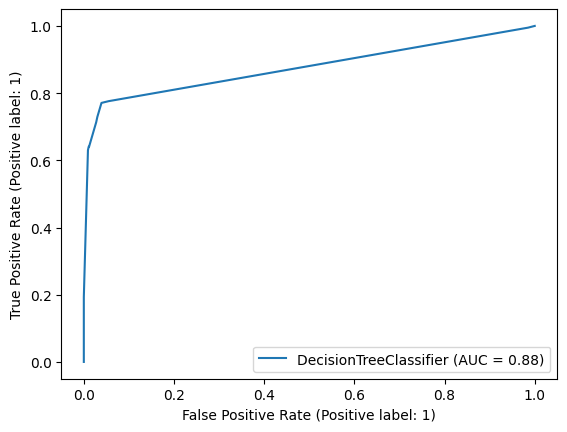

In [19]:
print("The ROC Curve is as: ")
RocCurveDisplay.from_estimator(classifier,X_test_cv,y_test)

In [20]:
# your custom input. uncomment to check.

# test=input("enter text: ")
# test=[test]
# test = cv.transform(test)
# test=test.toarray()
# print(classifier.predict(test))

In [21]:
# test=input("enter text: ")
test="you have won a lottery"
test=[test]
test = cv.transform(test)
test=test.toarray()
print(classifier.predict(test))

[1]


In [22]:
# test=input("enter text: ")
test="you have won a vacation trip"
test=[test]
test = cv.transform(test)
test=test.toarray()
print(classifier.predict(test))

[1]


In [23]:
# here, 1 means spam and 0 means ham. This was renamed in upper cells.

In [ ]:
# you have won a lottery
# you have won a vacation trip